# Plant Monitoring System  
---

## Objetivo

* Este notebook utiliza sensores de Grove que miden la temperatura, el nivel de humedad y la luminosidad para crear un invernadero monitorizado para controlar que las plantas tengan las mejores condiciones para vivir. Las condiciones son monitoreadas en el stick LED de Grove y el zumbador de Grove. Se genera una alerta si las condiciones valoradas en conjunto no son las adecuadas. También notifica mediante un correo electrónico si una planta está enferma o tiene una plaga.  


## Referencias
* [Grove water_sensor](https://www.seeedstudio.com/Grove-Water-Sensor.html) 
* [Grove temperature](https://www.seeedstudio.com/Grove-Temperature-Sensor.html) 
* [Grove light_sensor](https://www.seeedstudio.com/Grove-Light-Sensor-v1-2-LS06-S-phototransistor.html) 
* [Grove buzzer](https://www.seeedstudio.com/Grove-buzzer.html)  
* [Grove servo](https://www.seeedstudio.com/Grove-Servo-Sensor.html) 
* [Grove Base Shield V2.0](https://www.seeedstudio.com/Base-Shield-V2.html)   

## Última vez que fue revisado
* 16 Enero 2022
    + Initial version
---

## Cargar _base_ Overlay

In [2]:
from time import sleep

from IPython.display import display, HTML
from pynq.overlays.base import BaseOverlay
from pynq_peripherals import ArduinoSEEEDGroveAdapter

base = BaseOverlay('base.bit')

## Construcción de la aplicación con Grove Base Shield V2.0 (Arduino)

<div class="alert alert-box alert-danger">
      
    <h4 class="alert-heading">¡Deténgase antes de continuar!   </h4>
    <ul>
     Asegúrese de haber conectado todos los sensores antes de encender la placa. Si los sensores están conectados mientras la placa está ENCENDIDA, puede hacer que el sistema se apague. Para un uso seguro, puede anotar las conexiones que se muestran a continuación, apagar la placa, hacer las conexiones físicas y volver a encender la placa. </ul>
    
   <h4 class="alert-heading">Hacer conexiones físicas </h4>
    <ul>
        <li>Inserte el protector de la base Grove en el conector Arduino de la placa.</li>
        <li>Conecte el módulo grove_temperature al conector A1 de Grove Base Shield.</li>
        <li>Conecte el módulo grove_light al conector A2 de Grove Base Shield.</li>
        <li>Conecte el módulo grove_servo al conector D4 de Grove Base Shield.</li>
        <li>Conecte el módulo grove_water_sensor al conector D5 de Grove Base Shield.</li>
        <li>Conecte el módulo grove_buzzer al conector D6 de Grove Base Shield.</li>
        <li>Conecte el módulo grove_led_stick al conector D7 de Grove Base Shield.</li></ul>
</div>

![](images/dry_arduino.png)

### Configurar el adapter

In [4]:
adapter = ArduinoSEEEDGroveAdapter(base.ARDUINO,
                                   A1='grove_temperature',
                                   A2 = 'grove_light', 
                                   D4='grove_servo',
                                   D5='grove_water_sensor',
                                   D6='grove_buzzer',
                                   D7='grove_led_stick')

### Definir objetos de dispositivo

In [5]:
temp_sensor = adapter.A1
light_sensor = adapter.A2
servo = adapter.D4
water_sensor = adapter.D5
buzzer = adapter.D6
led_stick = adapter.D7

### Importar librerías necesarias

Importamos las librerías necesarias:

In [6]:
import cv2
import imutils
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import smtplib
import os
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
import paho.mqtt.client as mqtt
import json
import matplotlib.pyplot as plt
import random
import time

### Definir las funciones

Para el funcionamiento del invernadero monitorizado definimos las siguientes funciones.

Definiremos las funciones que harán funcionar los sensores e interactuar entre ellos, la función que detecta enfermedades en las plantas, la función que envía un correo electrónico entre otras.  
* <code>level_conditions_winter()</code> calcula el nivel de condiciones atmosféricas.
* <code>led_meter()</code> enciende las luces LED.
* <code>enable_buzzer()</code> hace funcionar el zumbador.
* <code>open_servo()</code> hace funcionar el servo.
* <code>plant_disease_detection</code> detecta si una planta está enferma y calcula el porcentaje de hoja dañada.
<div class="alert alert-box alert-info"> A esta función le pasamos una imagen que se pintó artificialmente de antemano con un pincel en blanco en el lugar donde las hojas tienen plagas y enfermedades. Le realizamos un procesado que convierte el follaje de la imagenNuevo a una imagen en blanco y negro y le realizamos procesamiento gaussiano con <code>GaussianBlur()</code> en el follaje de la imagen. Después le pasamos una imagen que tiene pintada la hoja por completo y la convertimos nuevamente en una imagen en blanco y negro y le volvemos a realizar un procesamiento gaussiano.   
Para hacer la comparación entre las dos imágenes y calculamos sus diferencias. Nos interesa comparar el área de la imagen con su contorno, por tanto realizamos una detección de bordes con <code>Canny()</code>. 
Por último, calculamos el área de la zona verde de la hoja, dividimos por el área total y le restamos 100 para calcular el área no sana.</div>  
<div></div>
* <code>email_disease</code> envía un email cuando se detecta un porcentaje elevado de enfermedad en la planta.
* <code>email_summary</code> envía un email cuando se detecta un porcentaje elevado de enfermedad en la planta.
* <code>graphics</code> visualiza los gráficos de la temperatura y la luminosidad a tiempo real.
* <code>again</code> repite el código necesario para hacer funcionar el monitor de invernadero.
* <code>on_connect</code> pone en funcionamiento la conexión a MQTT.
* <code>conexion_mqtt</code> hace lo necesario para conectarse con MQTT.

Funciones de los sensores y la interacción entre ellos:

In [21]:
def level_conditions_winter(temperature, dry):
    """Indicador de idoneidad de las condiciones atmosféricas.
    En función de la temperatura y de si la tierra está mojada 
    o no devuelve un nivel del 1 al 10.
    
    Parámetros:
        temperature: temperatura recogida por el sensor
    de temperatura
        dry: booleano recogido por el sensor de agua
    
    Returns:
        level: el nivel del 1 al 10
    """
    level = 5
    
    if 16 <= temperature <= 22:
        level += 1
        
        if 17 <= temperature <= 21:
            level += 1
            
            if 18 <= temperature <= 20:
                level += 1
                
    elif temperature < 18 or temperature > 20:
        level -= 1
        
        if temperature < 17 or temperature > 21:
            level -= 1
    if dry:
        level -= 3
        
    if not dry:
        level += 2
        
    if level <=0:
        level = 1
        
    else:
        pass
    
    return level
    
# Rango de colores desde rojo --> amarillo --> verde
led_colors = [0xFF0000, 0xF22800, 0xFF3B05, 0xFD8807, 0xFBC709,
              0xEBFD07, 0xB1FD07, 0x6BFC08, 0x14FC08, 0x05FF05] 

def led_meter(level):
    """Luces led.
    En función del nivel de level_conditions_winter las luces
    led se encenderán en un rango del 0 al 10 en los colores
    de led_colors.
    
    Parámetros:
        level: nivel de la salida de level_conditions_winter
    """
    for i in range(level):
        led_stick.set_pixel(i, led_colors[i])
        
    for j in range(9, level - 1, -1):
        led_stick.set_pixel(j, 0)
    led_stick.show()


def enable_buzzer(level):
    """Activador de buzzer.
    Activa el buzzer cuando el nivel de level_conditions_winter
    sea superior a 5.
    
    Parámetros:
        level: nivel de la salida de la función 
    level_conditions_winter
    """
    if level <= 4:
        buzzer.play_note("C4", 1000)
        
    else:
        pass
        
        
def open_servo(temperature,sec,count,count_day,moisture, light):
    """Abrir servo.
    El servo funciona de manera automática si se presiona
    el botón 0 (abriéndose cuando haga frío o calor y cerrándose
    en caso contrario) y de manera manual cuando se desactive
    el modo manual y se abrirá y cerrará con el switch 1.
    
    Parámetros:
        temperature: temperatura recogida por el sensor
    de temperatura
        sec: secuencias para utilizarlo en la función again
        count: contador para utilizarlo en la función again
        count_day: contador para utilizarlo en la función again
        moisture: booleano que indica si hay humedad o no para
    utilizarlo en la función again
        light: nivel de luminosidad para utilizarlo en la 
    función again
    
    Returns:
        sec: secuencias
        count: contador
        count_day: contador
    """
    if base.buttons[0].read()!=0:
        ventilador = True
        sleep(2)
        
        while ventilador:
            base.leds[0].on()
            sec,count,count_day,temperature, moisture, light = again(sec,count,count_day)
            sleep(1)
            
            if temperature < 18 or temperature > 20:
                servo.set_angular_position(180)
                
            else:
                servo.set_angular_position(0)
                
            if base.buttons[0].read()!=0:
                base.leds[0].off()
                sleep(2)
                ventilador=False
                
    else:                        
        base.leds[0].off()
        
        if base.switches[1].read()!=1:
            servo.set_angular_position(0)
            
        else:
            servo.set_angular_position(180)
            
    return sec,count,count_day
            

Función de la detección de plagas:

In [8]:
def plant_disease_detection(path1, path2, count):
    """Detector de plagas en plantas.
    Mediante un preprocesado de imágenes consigue dar un 
    porcentaje del daño provocado por plagas y enfermedades. 
    Requiere de dos imágenes de la hoja de la planta: una 
    con la zona enferma pintada en blanco previamente y otra
    con la hoja pintada en blanco por completo.
    Utiliza las librerías cv2, imutils, Image, ImageDraw,
    ImageFont y numpy. 
    
    Parámetros:
        path1: directorio de la foto de la imagen con 
    la zona enferma pintada en blanco previamente.
        path2: directorio de la foto de la imagen con 
    la hoja pintada en blanco previamente.
        count: contador de las veces que se ha ejecutado 
    la función. Servirá para solo detectar la enfermedad una vez.
    
    Returns:
        scale: porcentaje de planta enferma
        count: contador de veces que se ha ejecutado la función
    """
    count = count + 1
    
    PSpicture = cv2.imread(path1)
    PSpicture = cv2.cvtColor(PSpicture, cv2.COLOR_BGR2GRAY)
    PSpictureGS = cv2.GaussianBlur(PSpicture, (21, 21), 0)
    originalPicture = cv2.imread(path2)
    originalPicture = cv2.cvtColor(originalPicture, cv2.COLOR_BGR2GRAY)
    originalPictureGS = cv2.GaussianBlur(originalPicture, (21, 21), 0)
    pictureDelta = cv2.absdiff(PSpictureGS, originalPictureGS)
    
    x, y = pictureDelta.shape

    img = cv2.GaussianBlur(pictureDelta, (3, 3), 0)
    canny = cv2.Canny(img, 0, 100)

    LeafArea = 0
    greenLeafArea = 0
    distinguishLeaf = []

    for i in range(x):
        for j in range(y): 
            distinguishLeaf.append([i, j])

    for t in distinguishLeaf: 
        k, l = t
        LeafArea = LeafArea + 1
        if img[k, l] != 0:
            greenLeafArea += 1

    scale = 100 - (greenLeafArea/LeafArea)*100

    return scale, count
    

Función para mandar un correo en caso de enfermedad en plantas:

In [9]:
def email_disease(porcentaje, ImgFileName):
    """Enviar correo electrónico.
    Si el porcentaje de la planta enferma supera el 30% entonces
    se enviará un correo electrónico notificándolo. Necesita la
    librería smtplib, os, MIMEMultipart, MIMEText y MIMEImage.
    
    Parámetros:
        porcentaje: es el porcentaje de planta enferma que
    sale de la función detectar_plagas.
        ImgFileName: es el path de la imagen de la planta 
    enferma
    """
    if porcentaje > 30:
        print("Plaga detectada! Enviando correo...")
        img_data = open(ImgFileName, 'rb').read()
        msg = MIMEMultipart()
        msg['Subject'] = 'Advertencia del invernadero'
        msg['From'] = 'su_correo'
        msg['To'] = 'correo_destino'
        

        text = MIMEText("Las hojas estan danyadas por plagas y enfermedades. El porcentaje de la superficie foliar de plagas y enfermedades es: " + str (round(porcentaje,2)) + '%')
        msg.attach(text)
        image = MIMEImage(img_data, name=os.path.basename(ImgFileName))
        msg.attach(image)

        s = smtplib.SMTP_SSL("smtp.gmail.com", 465)

        s.login("su_correo","password")
        s.sendmail('esu_correo', 'correo_destino', msg.as_string())
        s.quit()
        print("Enviado!")
        
    else:
        pass
    

Función para enviar un correo con un resumen del día:

In [28]:
def email_summary(count_day):
    """Envia un correo al final del día con un resumen del 
    estado del invernadero.
    
    Parámetros:
        count_day: contador de veces que se ha ejecutado 
    la función.
    
    Returns:
        count_day: parámetro que indica que se ha ejecutado
    la función.
    """
    ImgFileName='graficas.png'
    count_day += 1
    print("Fin del día... Generando resumen...")
    print("Enviando correo...")
    
    img_data = open(ImgFileName, 'rb').read()
    msg = MIMEMultipart()
    msg['Subject'] = 'Resumen del dia de tu invernadero'
    msg['From'] = 'su_correo'
    msg['To'] = 'correo_destino'
    
    agua = round(np.mean(list_moist),2)
    if agua > 0.5:
        agua="sus plantas necesitan ser regadas"
    else:
        agua="sus plantas están en buen estado"

    horas = 0
    for i in list_light:
        if i > 50:
            horas += 1
        else:
            pass
    
    text = MIMEText("Este es un resumen de las condiciones de tus plantas en el invernadero. Temperatura media: " 
                    + str(round(np.mean(list_temp),2)) + ", luminosidad media: " 
                    + str(round(np.mean(list_light),2)) + ", horas de luz durante el día: " + str(horas) +  ", necesidad de riego: " 
                   + agua + "  nivel promedio: " + str(int(round(np.mean(list_level),2))) + " (recuerde que 1 es el peor nivel y 10 es el mejor nivel)."
                   )

    msg.attach(text)
    image = MIMEImage(img_data, name=os.path.basename(ImgFileName))
    msg.attach(image)

    s = smtplib.SMTP_SSL("smtp.gmail.com", 465)

    s.login("su_correo","password")
    s.sendmail('su_correo', 'correo_destino', msg.as_string())
    s.quit()
    print("Enviado!")
    return count_day


Función para gráficas:

In [11]:
def graphics(fig, axis, sec, list_sec, temperature, list_temp, light, list_light):
    """Visualización de gráficos.
    Visualiza a tiempo real la temperatura y el nivel de 
    luminosidad y lo guarda en un formato .png
    
    Parámetros:
        fig: figura del plot
        axis: ejes del plot
        sec: secuencias para dibujar el gráfico
        list_sec: lista de secuencias
        temperature: temperatura actual
        list_temp: lista de todas las temperaturas tomadas
        light: luminosidad actual
        list_light: lista de todas las luminosidades
    """

    fig.canvas.draw()
    fig.show()
         
    axis[0].plot(list_sec[-1], list_temp[-1], "bo", color="navy")
    axis[0].plot(list_sec, list_temp, color = "royalblue")
    axis[0].set_title("Temperatura")

    # For Cosine Function
    axis[1].plot(list_sec[-1], list_light[-1], "bo", color="darkgoldenrod")
    axis[1].plot(list_sec, list_light, color="gold")
    axis[1].set_title("Luminosidad en %")
    
    fig.savefig('graficas.png')

Función para repetir los datos recogidos por los sensores:

In [14]:
def again(sec,count,count_day):
    """Función para repetir la interacción de los sensores.
    Sirve para repetir el funcionamiento de la base del 
    monitor de invernadero.
    
    Parámetros:
        sec: secuencias para dibujar los gráficos
        count: contador que determina si se pasa por la
    función de detección de plagas
        count_day: contador que determina si se pasa por la 
    función de enviar correo resumen
    """
    sec+=1

    temperature = round(temp_sensor.get_temperature()- 23, 2) 
    moisture = water_sensor.is_dry()
    light = round(light_sensor.get_intensity(), 2)
    list_sec.append(sec)
    list_temp.append(temperature)
    list_light.append(light)
    list_moist.append(int(moisture))

    #LED
    level = level_conditions_winter(temperature, moisture)
    list_level.append(level)
    led_meter(level)
    
    #Buzzer
    enable_buzzer(level)
    
    #Detección de enfermedades e-mail
    if count == 0:
        path1 = "./fotos/enfermas/6f27be21b8229911b9075e4bb7576473.png"
        path2 = "./fotos/enfermas/08b287a26fecf5b35d4db593f1f5674c.png"
        porcentaje, count = plant_disease_detection(path1, path2, count)
        email_disease(porcentaje, path1)
    
    #MQTT
    #Temperatura
    mqg_temperatura = json.dumps({"temperatura":temperature})
    client.publish("pynq_iot_temperatura", mqg_temperatura, qos=0, retain=False)
    client.loop()
    
    #Luz
    mqg_luz = json.dumps({"luz":light})
    client.publish("pynq_iot_luz", mqg_luz, qos=0, retain=False)
    client.loop()
    
    #Agua
    if moisture == True:
        texto_agua = "Seco"
    else:
        texto_agua = "Mojado"
    mqg_agua = json.dumps({"agua":texto_agua})
    client.publish("pynq_iot_agua", mqg_agua, qos=0, retain=False)
    client.loop()
    
    #Level
    mqg_level = json.dumps({"level":level})
    client.publish("pynq_iot_level", mqg_level, qos=0, retain=False)
    client.loop()
    
    #Gráficas
    graphics(fig, axis, sec, list_sec, temperature, list_temp, light, list_light)
    
    #Correo final
    actual = time.time()
    if actual-start > 60 and count_day == 0:
        count_day = email_summary(count_day)
        
    

    sleep(0.8)
    return sec,count,count_day,temperature, moisture, light

Función para realizar las conexiones con MQTT Dash:

In [15]:
def on_connect (client, userdata, flags, rc):
    if rc == 0:
        client.connected_flag = True
        print ("Connected OK")
        return
    
    print ("Failed to connect to %s, error was, rc=%s" % rc)
    sys.exit (-1)
    
def conexion_mqtt():
    host          = "node02.myqtthub.com"
    port          = 1883
    clean_session = True
    client_id     = "lab_iot"
    user_name     = "dsdc_iot_mqtt"
    password      = "TesT!2120"

    # Create MQTT client with clientId, host, user and password
    client = mqtt.Client (client_id = client_id, clean_session = clean_session)
    client.username_pw_set (user_name, password)

    # Set events
    client.on_connect = on_connect

    # Connect using standard unsecure MQTT with keepalive to 60
    client.connect (host, port, keepalive = 60)
    client.connected_flag = False
    while not client.connected_flag: #wait in loop
        client.loop()
        sleep (1)   
    return client

<div class="alert alert-box alert-info">
   <h4 class="alert-heading">Notas antes de ejecutar la siguiente celda </h4>
    <ul>
        <li> El interruptor de palanca SW0 en la placa PYNQ-Z2 se usa para habilitar o deshabilitar el monitor de invernadero.</li>
        <li> El interruptor de palanca SW1 en la placa PYNQ-Z2 se usa para abrir o cerrar el servo que hace la función de aire acondicionado.</li>
        <li> El botón BTN0 en la placa PYNQ-Z2 se usa para automatizar el servo en función de la temperatura.Para activarlo mantener pulsado hasta que se ilumine la luz del botón.</li>
        <li> Si el botón BTN0 está activado el interruptor de palanca SW1 no podrá ser utilizado.</li>
        <li> Dado que el sensor de agua está comprobando la humedad del suelo, si el sensor está seco y la temperatura está fuera de los límites establecidos como óptimos, el zumbador se encenderá tan pronto como haga funcionar la celda.</li>
        <li> Puede usar un pañuelo húmedo y colocarlo en el sensor de agua con buen contacto para simular la humedad del suelo.</li>
        <li> El sensor de temperatura es lo suficientemente sensible para medir el cambio cuando se coloca un dedo sobre él.</li>
        <li> Para apagar el monitor es necesario desactivar el servo del modo automático. </li>
    </ul>
</div>

## Monitor de invernadero

Para poner en funcionamiento el monitor de invernadero, ejecute la siguiente celda:

Connected OK


<IPython.core.display.Javascript object>


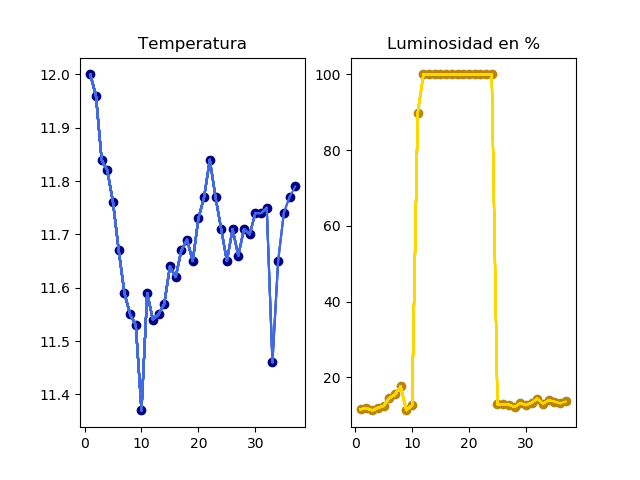

Plaga detectada! Enviando correo...
Enviado!
Fin del día... Generando resumen...
Enviando correo...
Enviado!
Hasta luego!


In [29]:
%matplotlib notebook

count = 0
client = conexion_mqtt()

sec = 0
fig, axis = plt.subplots(1, 2)

start = time.time()
count_day = 0

list_sec = []
list_light = []
list_temp = []
list_moist = []
list_level = []

while base.switches[0].read()==1:
    sec+=1
    
    temperature = round(temp_sensor.get_temperature()- 23, 2) 
    moisture = water_sensor.is_dry()
    light = round(light_sensor.get_intensity(), 2)
    
    list_sec.append(sec)
    list_temp.append(temperature)
    list_light.append(light)
    list_moist.append(int(moisture))

    #LED
    level = level_conditions_winter(temperature, moisture)
    list_level.append(level)
    led_meter(level)
    
    #Buzzer
    #enable_buzzer(level)

    #SERVO
    sec,count,count_day = open_servo(temperature, sec,count,count_day,moisture, light)
    
    #Detección de enfermedades e-mail
    if count == 0:
        path1 = "./fotos/enfermas/6f27be21b8229911b9075e4bb7576473.png"
        path2 = "./fotos/enfermas/08b287a26fecf5b35d4db593f1f5674c.png"
        porcentaje, count = plant_disease_detection(path1, path2, count)
        email_disease(porcentaje, path1)
    
    #MQTT
    #Temperatura
    mqg_temperatura = json.dumps({"temperatura":temperature})
    client.publish("pynq_iot_temperatura", mqg_temperatura, qos=0, retain=False)
    client.loop()
    
    #Luz
    mqg_luz = json.dumps({"luz":light})
    client.publish("pynq_iot_luz", mqg_luz, qos=0, retain=False)
    client.loop()
    
    #Agua
    if moisture == True:
        texto_agua = "Seco"
    else:
        texto_agua = "Mojado"
    mqg_agua = json.dumps({"agua":texto_agua})
    client.publish("pynq_iot_agua", mqg_agua, qos=0, retain=False)
    client.loop()
    
    #Level
    mqg_level = json.dumps({"level":level})
    client.publish("pynq_iot_level", mqg_level, qos=0, retain=False)
    client.loop()
    
    #Gráficas
    graphics(fig, axis, sec, list_sec, temperature, list_temp, light, list_light)
    
    #Correo final
    actual = time.time()
    if actual-start > 80 and count_day == 0:
        count_day = email_summary(count_day)
        
    
    sleep(1)
    

led_stick.clear()
client.disconnect()
print("Hasta luego!")

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: BSD-3-Clause

----

----